In [14]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))

In [15]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn

In [16]:
from utils.helper import *

In [17]:
df = pd.read_csv("../../data/Final_Btc_Data_with_Indicators.csv", parse_dates=['Date'])

In [18]:
target_col = "Price"
features = [col for col in df.columns if col != target_col and col != "Date"]

df = scaled_data(df)

seq_len = 15
horizon = 1
X, y = create_sequences(df[features].values, df[target_col].values, seq_len, horizon)

/Users/sohamsamal/Documents/Coding/Research/research-btc-pred/venv/lib/python3.11/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [19]:
batch_size = 256

train_loader, val_loader, test_loader = data_loaders(df, X, y, batch_size=batch_size)

In [20]:
# torch.Size([256, 5, 14]) -> [B, T, F]
# torch.Size([256])        -> [B]

class BaselineLSTM(nn.Module):
    def __init__(self, input_dim, hidden1=64, hidden2=32, dropout=0.2):
        super().__init__()
        self.lstm1 = nn.LSTM(input_size=input_dim, hidden_size=hidden1, batch_first=True)
        self.drop1 = nn.Dropout(dropout)
        self.lstm2 = nn.LSTM(input_size=hidden1, hidden_size=hidden2, batch_first=True)
        self.fc = nn.Linear(hidden2, 1)

    def forward(self, x):
        # x: (B, T, F)
        out, _ = self.lstm1(x)
        out = self.drop1(out)
        out, _ = self.lstm2(out)

        # take last time step
        out = out[:, -1, :]
        out = self.fc(out)
        return out.squeeze(-1)    # (B,)

In [21]:
lstm = BaselineLSTM(input_dim=len(features))

# Device
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

device

device(type='mps')

In [22]:
# Training the model using the train_loader, val_loader, and test_loader
lstm = lstm.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.001)

num_epochs = 300
best_val_loss = float('inf')
patience = 10
patience_counter = 0

# Load existing model's best validation loss if it exists
existing_model_path = '../../models/temp_models/lstm15.pth'
existing_best_val_loss = float('inf')

if os.path.exists(existing_model_path):
    try:
        # Create a temporary model to load and evaluate the existing model
        temp_lstm = BaselineLSTM(input_dim=len(features)).to(device)
        temp_lstm.load_state_dict(torch.load(existing_model_path))
        temp_lstm.eval()

        # Evaluate existing model on validation set
        existing_val_loss = 0.0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = temp_lstm(batch_x)
                loss = criterion(outputs, batch_y)
                existing_val_loss += loss.item()

        existing_best_val_loss = existing_val_loss / len(val_loader)
        print(f"Existing model validation loss: {existing_best_val_loss:.6f}")

        # Delete temporary model to free memory
        del temp_lstm
        torch.cuda.empty_cache() if torch.cuda.is_available() else None

    except Exception as e:
        print(f"Could not load existing model: {e}")
        existing_best_val_loss = float('inf')

train_losses = []
val_losses = []

print(f"Training on device: {device}")
print(f"Model parameters: {sum(p.numel() for p in lstm.parameters())}")

for epoch in range(num_epochs):

    print(f"{'='*40}")
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"{'-'*40}")

    lstm.train()
    train_loss = 0.0

    for batch_x, batch_y in tqdm(train_loader):
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = lstm(batch_x)
        loss = criterion(outputs, batch_y)

        # Backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    lstm.eval()
    val_loss = 0.0

    with torch.no_grad():
        for batch_x, batch_y in tqdm(val_loader):
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            outputs = lstm(batch_x)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # Early stopping and model saving
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
    else:
        patience_counter += 1

    print(f'Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')

    # Early stopping check
    if patience_counter >= patience:
        print(f'Early stopping triggered after epoch {epoch+1}')
        break

# After training is complete, compare with existing model and save only if better
if best_val_loss < existing_best_val_loss:
    torch.save(lstm.state_dict(), existing_model_path)
    print(f'\nNew model is better! Saved with validation loss: {best_val_loss:.6f}')
    print(f'Previous best was: {existing_best_val_loss:.6f}')
else:
    print(f'\nExisting model is better. Not saving new model.')
    print(f'New model validation loss: {best_val_loss:.6f}')
    print(f'Existing model validation loss: {existing_best_val_loss:.6f}')

print(f'\nBest validation loss achieved this training: {best_val_loss:.6f}')

Training on device: mps
Model parameters: 33057
Epoch 1/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 151.71it/s]


Epoch [1/300] - Train Loss: 1.177428, Val Loss: 17.667981
Epoch 2/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 195.60it/s]


Epoch [2/300] - Train Loss: 0.983024, Val Loss: 15.950838
Epoch 3/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 329.06it/s]


Epoch [3/300] - Train Loss: 0.784731, Val Loss: 13.742953
Epoch 4/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 246.73it/s]


Epoch [4/300] - Train Loss: 0.624062, Val Loss: 11.411923
Epoch 5/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 217.84it/s]


Epoch [5/300] - Train Loss: 0.527021, Val Loss: 9.433064
Epoch 6/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 320.97it/s]


Epoch [6/300] - Train Loss: 0.442139, Val Loss: 7.982871
Epoch 7/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 187.12it/s]


Epoch [7/300] - Train Loss: 0.367565, Val Loss: 6.787338
Epoch 8/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 325.67it/s]


Epoch [8/300] - Train Loss: 0.312778, Val Loss: 5.641215
Epoch 9/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 297.58it/s]


Epoch [9/300] - Train Loss: 0.269319, Val Loss: 4.716169
Epoch 10/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 334.85it/s]


Epoch [10/300] - Train Loss: 0.234995, Val Loss: 4.005347
Epoch 11/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 205.73it/s]


Epoch [11/300] - Train Loss: 0.204864, Val Loss: 3.381806
Epoch 12/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 234.72it/s]


Epoch [12/300] - Train Loss: 0.180650, Val Loss: 2.925196
Epoch 13/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 181.99it/s]


Epoch [13/300] - Train Loss: 0.164334, Val Loss: 2.512792
Epoch 14/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 329.91it/s]


Epoch [14/300] - Train Loss: 0.156538, Val Loss: 2.292883
Epoch 15/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 149.00it/s]


Epoch [15/300] - Train Loss: 0.138339, Val Loss: 1.948262
Epoch 16/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 301.88it/s]


Epoch [16/300] - Train Loss: 0.122667, Val Loss: 1.853239
Epoch 17/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 194.40it/s]


Epoch [17/300] - Train Loss: 0.108334, Val Loss: 1.602887
Epoch 18/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 321.80it/s]


Epoch [18/300] - Train Loss: 0.100660, Val Loss: 1.448467
Epoch 19/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 214.73it/s]


Epoch [19/300] - Train Loss: 0.092522, Val Loss: 1.319742
Epoch 20/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 177.79it/s]


Epoch [20/300] - Train Loss: 0.084425, Val Loss: 1.172247
Epoch 21/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 249.97it/s]


Epoch [21/300] - Train Loss: 0.077497, Val Loss: 1.062194
Epoch 22/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 235.01it/s]


Epoch [22/300] - Train Loss: 0.070375, Val Loss: 0.963265
Epoch 23/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 255.24it/s]


Epoch [23/300] - Train Loss: 0.064616, Val Loss: 0.889622
Epoch 24/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 304.56it/s]


Epoch [24/300] - Train Loss: 0.058817, Val Loss: 0.819952
Epoch 25/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 177.48it/s]


Epoch [25/300] - Train Loss: 0.053224, Val Loss: 0.751583
Epoch 26/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 260.73it/s]


Epoch [26/300] - Train Loss: 0.048440, Val Loss: 0.696051
Epoch 27/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 205.28it/s]


Epoch [27/300] - Train Loss: 0.045799, Val Loss: 0.642133
Epoch 28/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 343.05it/s]


Epoch [28/300] - Train Loss: 0.063138, Val Loss: 0.617367
Epoch 29/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 319.91it/s]


Epoch [29/300] - Train Loss: 0.101008, Val Loss: 0.604284
Epoch 30/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 248.10it/s]


Epoch [30/300] - Train Loss: 0.092835, Val Loss: 0.771593
Epoch 31/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 325.52it/s]


Epoch [31/300] - Train Loss: 0.049575, Val Loss: 0.579703
Epoch 32/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 353.28it/s]


Epoch [32/300] - Train Loss: 0.045858, Val Loss: 0.564124
Epoch 33/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 288.68it/s]


Epoch [33/300] - Train Loss: 0.046154, Val Loss: 0.646230
Epoch 34/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 53.86it/s]


Epoch [34/300] - Train Loss: 0.040206, Val Loss: 0.558195
Epoch 35/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 290.14it/s]


Epoch [35/300] - Train Loss: 0.032900, Val Loss: 0.643641
Epoch 36/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 291.38it/s]


Epoch [36/300] - Train Loss: 0.027787, Val Loss: 0.489661
Epoch 37/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 338.06it/s]


Epoch [37/300] - Train Loss: 0.025460, Val Loss: 0.473788
Epoch 38/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 345.37it/s]


Epoch [38/300] - Train Loss: 0.023038, Val Loss: 0.470594
Epoch 39/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 234.21it/s]


Epoch [39/300] - Train Loss: 0.021406, Val Loss: 0.478732
Epoch 40/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 202.11it/s]


Epoch [40/300] - Train Loss: 0.019634, Val Loss: 0.481052
Epoch 41/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 348.12it/s]


Epoch [41/300] - Train Loss: 0.019117, Val Loss: 0.494061
Epoch 42/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 351.86it/s]


Epoch [42/300] - Train Loss: 0.020881, Val Loss: 0.489010
Epoch 43/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 188.03it/s]


Epoch [43/300] - Train Loss: 0.027777, Val Loss: 0.522841
Epoch 44/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 332.22it/s]


Epoch [44/300] - Train Loss: 0.045132, Val Loss: 0.625358
Epoch 45/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 276.85it/s]


Epoch [45/300] - Train Loss: 0.019977, Val Loss: 0.477474
Epoch 46/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 343.94it/s]


Epoch [46/300] - Train Loss: 0.017097, Val Loss: 0.489592
Epoch 47/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 347.22it/s]


Epoch [47/300] - Train Loss: 0.015771, Val Loss: 0.519612
Epoch 48/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 309.18it/s]

Epoch [48/300] - Train Loss: 0.013643, Val Loss: 0.608924
Early stopping triggered after epoch 48

New model is better! Saved with validation loss: 0.470594
Previous best was: inf

Best validation loss achieved this training: 0.470594


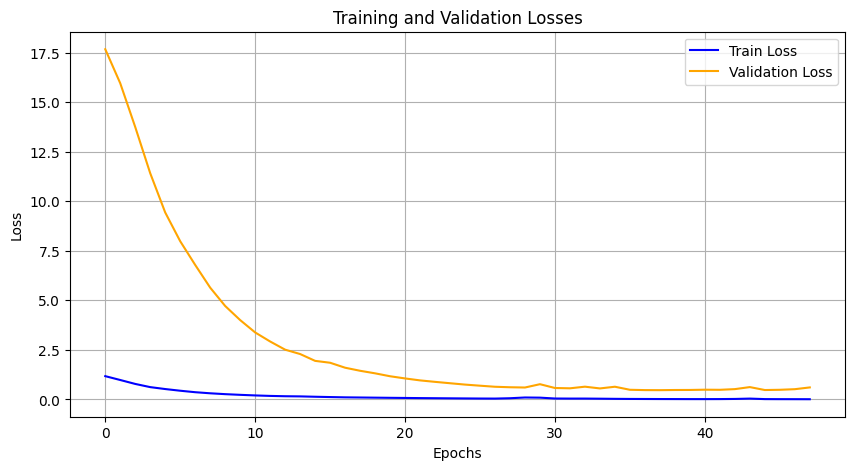

In [23]:
import matplotlib.pyplot as plt

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid()
plt.show()

In [24]:
lstm.load_state_dict(torch.load('../../models/temp_models/lstm15.pth'))

<All keys matched successfully>

In [25]:
# Test phase
lstm.eval()
test_loss = 0.0
test_predictions = []
test_targets = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        outputs = lstm(batch_x)
        loss = criterion(outputs, batch_y)
        test_loss += loss.item()

        test_predictions.extend(outputs.cpu().numpy())
        test_targets.extend(batch_y.cpu().numpy())

avg_test_loss = test_loss / len(test_loader)
print(f'Test Loss: {avg_test_loss:.6f}')

# Convert to numpy arrays for analysis
test_predictions = np.array(test_predictions)
test_targets = np.array(test_targets)

Test Loss: 0.344864


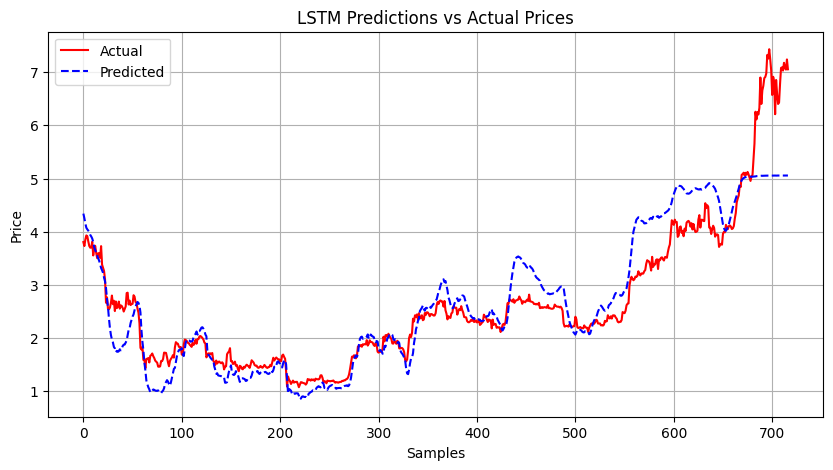

In [26]:
# plot predictions vs targets
plt.figure(figsize=(10, 5))
plt.plot(test_targets, label='Actual', color='red')
plt.plot(test_predictions, label='Predicted', color='blue', linestyle='--')
plt.xlabel('Samples')
plt.ylabel('Price')
plt.title('LSTM Predictions vs Actual Prices')
plt.legend()
plt.grid()
plt.show()